# Titanic Survival Part 3: Training Classifiers for Accuracy

In Part 1 of this project I conduct Exploratory Data Analysis (EDA) of the Titanic training data using R. This exploration can be found [here.](http://rpubs.com/BigBangData/512981)

In Part 2 I continue the exploration using Python and building a couple of basic models. This is not intended as the goal of the competition, just an exploration of modeling in Python.

In Part 3 (this notebook) I create a pre-processing pipeline and train several models in Python using the scikit-learn module, and submit my predictions to the competition.


## Pre-Processing

In [1]:
# import modules
import pandas as pd

# custom pre-processing module
import processing_pipeline as pp  

# load datasets
train_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test.csv")

# separate target from predictors in training set
survived_labels = train_data['Survived'].copy()
train_data_nolabel = train_data.drop('Survived', axis=1)

# get processed training data and labels
X = pp.process_train(train_data_nolabel)
y = survived_labels.to_numpy()

## Modeling

### Stochastic Gradient Descent

In [4]:
from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle
import numpy as np

# import custom modeling module
import modeling_functions as mf

# randomly shuffle data
np.random.seed(7)
X, y = shuffle(X, y)

# using first 80% of the data
train_data, train_labs = X[:700], y[:700]

# training first model
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(train_data, train_labs)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [5]:
# predict on the validation subset (remaining 20%)
val_data, val_labs = X[700:], y[700:]

val_accuracy = mf.predict_SGD(val_data, val_labs, sgd_clf)
val_accuracy

0.8848

### Random Forests

In [147]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)

y_prob_forest = cross_val_predict(forest_clf, X, y, cv=3, method="predict_proba")
y_scores_forest = y_prob_forest[:, 1]

y_scores_sgd = cross_val_predict(sgd_clf, X, y, cv=3,method="decision_function")

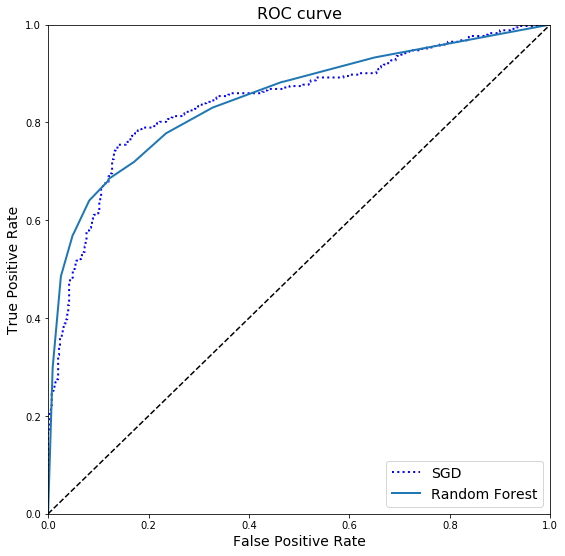

In [148]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC curve', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)

# calculating FPR and TPR for all Thresholds
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y, y_scores_forest)
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y, y_scores_sgd)

# plotting
plt.figure(figsize=(9, 9))
plt.plot(fpr_sgd, tpr_sgd, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=14)
plt.show()

In [149]:
# calculating the Area Under the Curve (AUC)
auc_sgd, auc_rf = np.array([roc_auc_score(y, y_scores_sgd), 
                            roc_auc_score(y, y_scores_forest)])

print('SGD          : ' +str(round(auc_sgd,4))\
   +'\nRandom Forest: ' +str(round(auc_rf,4)))

SGD          : 0.8435
Random Forest: 0.8471
